### Photon Efficiency

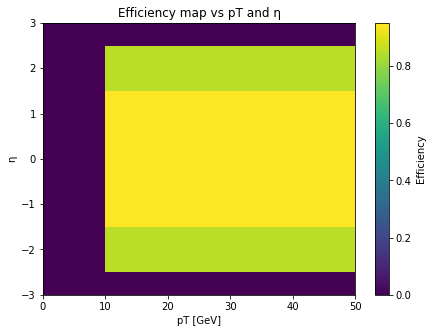

In [4]:
# Default Efficiency

import numpy as np
import matplotlib.pyplot as plt

# Define grid
pt = np.linspace(0, 50, 500)
eta = np.linspace(-3, 3, 500)
PT, ETA = np.meshgrid(pt, eta)

# Efficiency formula
eff = (
    (PT <= 10.0) * 0.00 +
    (np.abs(ETA) <= 1.5) * (PT > 10.0) * 0.95 +
    ((np.abs(ETA) > 1.5) & (np.abs(ETA) <= 2.5)) * (PT > 10.0) * 0.85 +
    (np.abs(ETA) > 2.5) * 0.00
)

# Plot
plt.figure(figsize=(7, 5))
plt.pcolormesh(PT, ETA, eff, shading='auto')
plt.colorbar(label='Efficiency')
plt.xlabel('pT [GeV]')
plt.ylabel('η')
plt.title('Efficiency map vs pT and η')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example sigmoid for E_T
def eff_et(ET, p0, p1, p2, p3):
    return p0 + p1 / (1 + np.exp(-(ET - p2) / p3))

# Example polynomial for eta
def eff_eta(eta, a0, a1, a2):
    return a0 + a1 * eta**2 + a2 * eta**4

# Load digitized data (you can use WebPlotDigitizer to extract points from your image)
ET_data = np.array([...])   # fill with x-values
eff_ET_data = np.array([...])
eta_data = np.array([...])
eff_eta_data = np.array([...])

# Fit
popt_ET, _ = curve_fit(eff_et, ET_data, eff_ET_data, p0=[0.97, 0.02, 12, 3])
popt_eta, _ = curve_fit(eff_eta, eta_data, eff_eta_data, p0=[0.985, -0.002, 0.0005])

# Plot fits
ET_range = np.linspace(0, 250, 200)
eta_range = np.linspace(-2.5, 2.5, 200)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(ET_data, eff_ET_data, label='Data')
plt.plot(ET_range, eff_et(ET_range, *popt_ET), 'r-', label='Fit')
plt.xlabel(r'$E_T$ [GeV]')
plt.ylabel('Efficiency')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(eta_data, eff_eta_data, label='Data')
plt.plot(eta_range, eff_eta(eta_range, *popt_eta), 'r-', label='Fit')
plt.xlabel(r'$\eta$')
plt.legend()
plt.show()


### Muon momentum resolution

$\frac{\sigma(p_T)}{p_T} = \frac{r_0}{p_T} \oplus r_1 \oplus r_2 \cdot p_T$

which is equal to

$\frac{\sigma(p_T)}{p_T} = \sqrt{\left(\frac{r_0}{p_T} \right)^2 + r_1^2 + (r_2\cdot p_T)^2}$

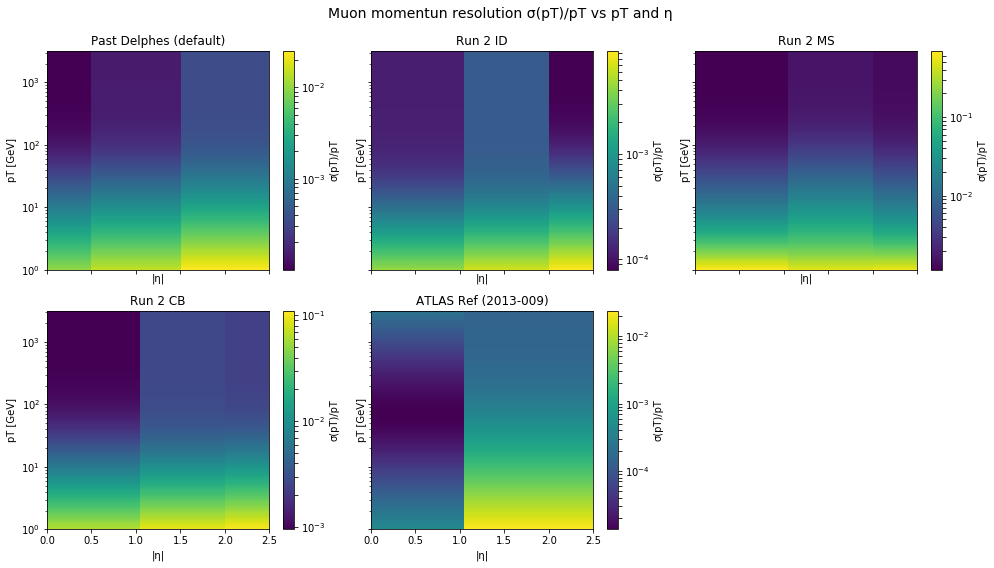

In [ ]:
# Study link: https://arxiv.org/pdf/2212.07338

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # <-- add this

# Define eta and pT grids
etas = np.linspace(0, 2.5, 200)
pts  = np.logspace(0, 3.5, 200)  # 1 GeV to ~3160 GeV
E, P = np.meshgrid(etas, pts)

scale = 10e-3
# ---------- OLD (past) resolution ----------
def past_res(pt, eta):
    return ((abs(eta) <= 0.5) * (pt > 0.1)* np.sqrt(0.01**2 + (pt*1.0e-4)**2)
          + ((abs(eta) > 0.5) & (abs(eta) <= 1.5)) * (pt > 0.1) * np.sqrt(0.015**2 + (pt*1.5e-4)**2)
          + ((abs(eta) > 1.5) & (abs(eta) <= 2.5)) * (pt > 0.1) * np.sqrt(0.025**2 + (pt*3.5e-4)**2))

# ---------- ID resolution ----------
def id_res(pt, eta):
    return ((abs(eta) < 1.05) * np.sqrt(0.0044**2 + (0.00012*pt)**2) +
            ((abs(eta) >= 1.05) & (abs(eta) < 2.0)) * np.sqrt(0.0067**2 + (0.00031*pt)**2) +
            (abs(eta) >= 2.0)  * np.sqrt(0.0094**2 + (0.00008*pt)**2))

# ---------- MS resolution ----------
def ms_res(pt, eta):
    return ((abs(eta) < 1.05) * np.sqrt((((71+63)/2)*scale/pt)**2 + (((13.5+17.2)/2)*scale)**2 + (((0.11+0.12)/2)*scale*pt)**2) +
            ((abs(eta) >= 1.05) & (abs(eta) < 2.0)) * np.sqrt((((42+44)/2)*scale/pt)**2 + (((26.7+29.2)/2)*scale)**2 + (((0.14+0.18)/2)*scale*pt)**2) +
            (abs(eta) >= 2.0) * np.sqrt((((61+47)/2)*scale/pt)**2 + (((16.8 + 17.8)/2)*scale)**2 + (((0.11+0.16)/2)*scale*pt)**2))

# ---------- CB resolution ----------
def cb_res(pt, eta):
    return ((abs(eta) <= 1.05) * np.sqrt((((6.7+6.5)/2)*scale)**2 + (((0.08 + 0.11)/2)*scale*pt)**2) +
            ((abs(eta) >= 1.05) & (abs(eta) < 2.0)) * np.sqrt((((10.3+8.9)/2)*scale)**2 + (((0.24 + 0.29)/2)*scale*pt)**2) +
            (abs(eta) >= 2.0) * np.sqrt((((10.6+11.5)/2)*scale)**2 + (((0.21 + 0.26)/2)*scale*pt)**2))

# ATLAS reference (ATL-PHYS-PUB-2013-009)
def atlas_ref(pt, eta):
    term_inner_A = pt*np.sqrt((0.24/pt)**2 + 0.02676**2 + (0.00012*pt)**2)
    term_outer_A = pt*np.sqrt(0.0388**2 + (0.00016*pt)**2)
    term_inner_C = np.sqrt(0.01607**2 + (0.000307*pt)**2)
    term_outer_B = np.sqrt(0.03**2 + (0.000387*pt)**2)
    term_inner_B = pt*np.sqrt(0.01061**2 + (0.000157*pt)**2)
    
    num = ( (abs(eta)<1.05)*term_inner_A*term_inner_C + (abs(eta)>=1.05)*term_outer_A ) * np.sqrt(0.03**2 + (0.000387*pt)**2)
    den = np.sqrt( ((abs(eta)<1.05)*term_inner_A + (abs(eta)>=1.05)*term_outer_A)**2 +
                   ((abs(eta)<1.05)*term_inner_B + (abs(eta)>=1.05)*pt*np.sqrt(0.03**2 + (0.000387*pt)**2))**2 )
    return num/den


# ---------- Compute fractional resolutions ----------
past_frac = past_res(P, E) / P
id_frac   = id_res(P, E) / P
ms_frac   = ms_res(P, E) / P
cb_frac   = cb_res(P, E) / P
atlas_frac = atlas_ref(P, E)/P

# ---------- Plot ----------
fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
fig.suptitle("Muon momentun resolution σ(pT)/pT vs pT and η", fontsize=14)

def make_plot(ax, Z, title):
    im = ax.pcolormesh(E, P, Z, shading='auto', cmap='viridis', norm=LogNorm())  # <-- fixed
    ax.set_title(title)
    ax.set_xlabel("|η|")
    ax.set_ylabel("pT [GeV]")
    ax.set_yscale('log')
    plt.colorbar(im, ax=ax, label="σ(pT)/pT")
    return im

make_plot(axs[0,0], past_frac,  "Past Delphes (default)")
make_plot(axs[0,1], id_frac,    "Run 2 ID")
make_plot(axs[0,2], ms_frac,    "Run 2 MS")
make_plot(axs[1,0], cb_frac,    "Run 2 CB")
make_plot(axs[1,1], atlas_frac, "ATLAS Ref (2013-009)")
axs[1,2].axis('off')

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

### Charged Hadron Tracking Efficiency

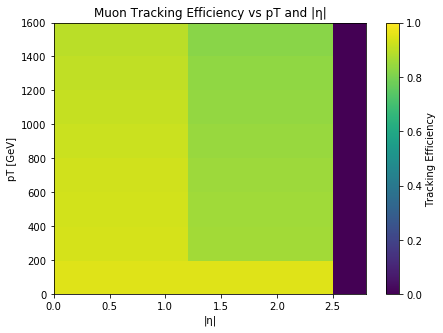

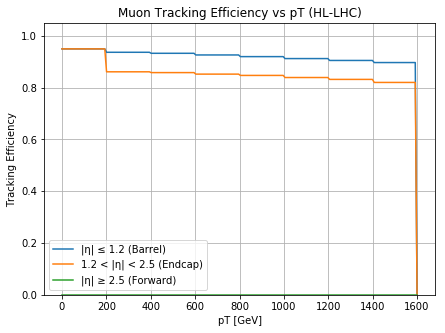

In [17]:
# source: https://arxiv.org/pdf/1704.07983

# Define eta and pT grids
etas = np.linspace(0, 2.8, 200)
pts  = np.linspace(0, 1600, 200)
E, P = np.meshgrid(etas, pts)

# --- Efficiency function from your TCL formula ---
def tracking_eff(pt, eta):
    # Barrel region (|η| <= 1.2)
    eff_barrel = (
        (pt < 200)*0.95 +
        ((pt >= 200) & (pt < 400))*0.93687 +
        ((pt >= 400) & (pt < 600))*0.93296 +
        ((pt >= 600) & (pt < 800))*0.92654 +
        ((pt >= 800) & (pt < 1000))*0.92011 +
        ((pt >= 1000) & (pt < 1200))*0.91257 +
        ((pt >= 1200) & (pt < 1400))*0.90531 +
        ((pt >= 1400) & (pt < 1600))*0.89721
    )

    # Endcap region (1.2 < |η| < 2.5)
    eff_endcap = (
        (pt < 200)*0.95 +
        ((pt >= 200) & (pt < 400))*0.86145 +
        ((pt >= 400) & (pt < 600))*0.85838 +
        ((pt >= 600) & (pt < 800))*0.85251 +
        ((pt >= 800) & (pt < 1000))*0.84749 +
        ((pt >= 1000) & (pt < 1200))*0.83939 +
        ((pt >= 1200) & (pt < 1400))*0.83212 +
        ((pt >= 1400) & (pt < 1600))*0.82039
    )

    # Combine all η regions
    return (
        (np.abs(eta) <= 1.2)*eff_barrel +
        ((np.abs(eta) > 1.2) & (np.abs(eta) < 2.5))*eff_endcap +
        (np.abs(eta) >= 2.5)*0
    )

# Compute efficiency
Z = tracking_eff(P, E)

# ---------- Plot 2D map ----------
plt.figure(figsize=(7,5))
plt.pcolormesh(E, P, Z, shading='auto', cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label="Tracking Efficiency")
plt.title("Muon Tracking Efficiency vs pT and |η|")
plt.xlabel("|η|")
plt.ylabel("pT [GeV]")
plt.ylim(0, 1600)
plt.show()

# ---------- 1D curves ----------
plt.figure(figsize=(7,5))
for eta_val, label in [(0.5, "|η| ≤ 1.2 (Barrel)"), (1.8, "1.2 < |η| < 2.5 (Endcap)"), (2.6, "|η| ≥ 2.5 (Forward)")]:
    eff_curve = tracking_eff(pts, eta_val)
    plt.plot(pts, eff_curve, label=label)

plt.xlabel("pT [GeV]")
plt.ylabel("Tracking Efficiency")
plt.title("Muon Tracking Efficiency vs pT (HL-LHC)")
plt.grid(True)
plt.legend()
plt.ylim(0, 1.05)
plt.show()
